In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [ ]:
import io
from google.colab import files
zipUpload = files.upload()

!unzip captcha.zip

Saving captcha.zip to captcha (1).zip
Archive:  captcha.zip
   creating: captcha/
  inflating: captcha/000 (2).jpg     
  inflating: captcha/000.jpg         
  inflating: captcha/002.jpg         
  inflating: captcha/008.jpg         
  inflating: captcha/009 (2).jpg     
  inflating: captcha/009.jpg         
  inflating: captcha/010.jpg         
  inflating: captcha/011 (2).jpg     
  inflating: captcha/011.jpg         
  inflating: captcha/012.jpg         
  inflating: captcha/013 (2).jpg     
  inflating: captcha/013 (3).jpg     
  inflating: captcha/013.jpg         
  inflating: captcha/014.jpg         
  inflating: captcha/015 (2).jpg     
  inflating: captcha/015 (3).jpg     
  inflating: captcha/015.jpg         
  inflating: captcha/016.jpg         
  inflating: captcha/017.jpg         
  inflating: captcha/018 (2).jpg     
  inflating: captcha/018.jpg         
  inflating: captcha/019 (2).jpg     
  inflating: captcha/019.jpg         
  inflating: captcha/021.jpg         
  infl

In [4]:
import os
### create a dataset for evaluate new numbers
predictionFilesPath= 'temp/' 

if not os.path.exists(predictionFilesPath):
		os.makedirs(predictionFilesPath)

prediction_folder= 'predict/' 

if not os.path.exists(prediction_folder):
		os.makedirs(prediction_folder)
  
predicted_folder= 'predicted/' 

if not os.path.exists(predicted_folder):
		os.makedirs(predicted_folder)
  
dataset_folder = 'dataset/'
if not os.path.exists('dataset/'):
		os.makedirs('dataset/')

In [5]:
from PIL import Image
from PIL import ImageFilter
import numpy as np



threshold = 150
class_counter=[0,0,0,0,0,0,0,0,0,0]

zero_array=[0] * 35
zero_array2D=[[0]*32 for i in range(32)]

max=[0,0]

def loadImagedirectory(path):
	return  os.listdir(path)


def evaluatePixel(p):
	if p > threshold:
		return 0
	else:
		return 255
	
def simplifyImage(path):
	loadedImage = Image.open(path)

	loadedImage = loadedImage.convert('L')
	image_filtered=loadedImage.filter(ImageFilter.UnsharpMask(radius = 7, percent = 300, threshold = 8))
	image_filtered=image_filtered.point(evaluatePixel)
	image_filtered= image_filtered.convert('1')
	return image_filtered


def clean_single_image(image):
	
	start_crop_point=-1
	start_crop = False
	end_crop_point= -1
	end_crop = False
	width, height = image.size
	

	for h in range(height):
		if not start_crop:
			for w in range(width):
				if not start_crop:
					if image.getpixel((w,h)) > threshold:
						start_crop_point = h
						start_crop= True
				else:
					break
		else:
			break


	for h in range(height-1,0,-1):
		if not end_crop:
			for w in range(width):
				if not end_crop:
					if image.getpixel((w,h)) > threshold:
						end_crop_point = h+1
						end_crop= True
				else:
					break
		else:
			break

	image = image.crop((0,start_crop_point,width,end_crop_point))

	width, height = image.size
	
	if width > max[0]:
		max[0] = width
		
	if height > max[1]:
		max[1] = height


	return image


def cropImagecoords(image):
	start_crop_point=-1
	start_crop = False
	end_crop_point= -1
	end_crop = False
	width, height = image.size

	
	for w in range(width):
		if not start_crop:
			for h in range(height):
				if not start_crop:
					if image.getpixel((w,h)) > threshold:
						start_crop_point = w
						start_crop= True
				else:
					break
		else:
			break


	for w in range(width-1,-1,-1):
		if not end_crop:
			for h in range(height):
				if not end_crop:
					if image.getpixel((w,h)) > threshold:
						end_crop_point = w
						end_crop= True
				else:
					break
		else:
			break
	return (start_crop_point,0,end_crop_point,height)

def makeSquare(image):
	zero_image = Image.fromarray(np.transpose(np.array(np.uint8(zero_array2D))),mode='L')
	zWidth,zheight = zero_image.size
	width,height = image.size	
	startX=0
	startY=0
	startX=int(zWidth/2 - width/2)
	startY=int(zheight/2 - height/2)

	zero_image.paste(image,(startX,startY))

	return zero_image


def ImageSplit(image):
	width , height = image.size
	
	imageAslist=[]
	col_list=[]
	img0=[]
	img1=[]
	img2=[]
	for w in range(width):
		for h in range(height):
			col_list.append(image.getpixel((w,h)))
		imageAslist.append(col_list)
		
		col_list=[]
	
	if width % 3 == 1:
		imageAslist.insert(0,zero_array)
		imageAslist.append(zero_array)
		
	elif width % 3 == 2:
		imageAslist.append(zero_array)

	short_width = int(len(imageAslist)/3)

	for i in range(0,short_width):
		img0.append(imageAslist[i])
	for i in range(short_width, short_width*2):
		img1.append(imageAslist[i])
	for i in range(2*short_width,3*short_width):
		img2.append(imageAslist[i])
	
	return (img0,img1,img2)

def createSingleImages(path,savepath,item):
	
	item0_class=int(item[0])
	item1_class=int(item[1])
	item2_class=int(item[2])
	

	img = simplifyImage(path+item)
	#img.save(f"{savepath}_orginal_{item}.png")
 

	# crop and split image in 3 pieces
	img=img.crop(cropImagecoords(img))
	
	img0,img1,img2=ImageSplit(img)


	img0=Image.fromarray(np.transpose(np.array(np.uint8(img0))),mode='L')
	img1=Image.fromarray(np.transpose(np.array(np.uint8(img1))),mode='L')
	img2=Image.fromarray(np.transpose(np.array(np.uint8(img2))),mode='L')


	#crop vertically and make squre single images from splited numbers
	img0=clean_single_image(img0)
	img0= makeSquare(img0)

	img1=clean_single_image(img1)
	img1= makeSquare(img1)

	img2=clean_single_image(img2)
	img2= makeSquare(img2)
	

	class_counter[item0_class] +=1
	img0.save(f"{savepath}Class_{item0_class}/{item0_class}_{str(class_counter[item0_class]).zfill(5)}_orginal_{item[0:14]}.png")

	class_counter[item1_class] +=1
	img1.save(f"{savepath}Class_{item1_class}/{item1_class}_{str(class_counter[item1_class]).zfill(5)}_orginal_{item[0:14]}.png")
	
	class_counter[item2_class] +=1
	img2.save(f"{savepath}Class_{item2_class}/{item2_class}_{str(class_counter[item2_class]).zfill(5)}_orginal_{item[0:14]}.png")
	

def createSingleImages_predict(path,savepath,item):

	img = simplifyImage(path+item)

	img=img.crop(cropImagecoords(img))
	
	img0,img1,img2=ImageSplit(img)


	img0=Image.fromarray(np.transpose(np.array(np.uint8(img0))),mode='L')
	img1=Image.fromarray(np.transpose(np.array(np.uint8(img1))),mode='L')
	img2=Image.fromarray(np.transpose(np.array(np.uint8(img2))),mode='L')


	img0=clean_single_image(img0)
	img0= makeSquare(img0)

	img1=clean_single_image(img1)
	img1= makeSquare(img1)

	img2=clean_single_image(img2)
	img2= makeSquare(img2)
	

	if not os.path.exists("/temp/"):
		os.makedirs("/temp")


	img0.save(f"{savepath}firstnumber_orginal_{item[0:14]}.png")

	img1.save(f"{savepath}secondnumber_orginal_{item[0:14]}.png")
	
	img2.save(f"{savepath}thirdnumber_orginal_{item[0:14]}.png")


def run_create_dataset():
	
	path= "./captcha/"
	save_path= "./dataset/"
	
	for i in range(10):
		if not os.path.exists(f"{save_path}Class_{i}"):
			os.makedirs(f"{save_path}Class_{i}")

	images_list = loadImagedirectory("./captcha/")
	for i in range(len(images_list)):
		createSingleImages(path,save_path,images_list[i])


def run_prediction_image_preprocess():
  path= "predict/"
  save_path= "temp/"
  images_list = loadImagedirectory(path)
  for i in range(len(images_list)):
    createSingleImages_predict(path,save_path,images_list[i])




In [6]:
run_create_dataset()

In [7]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory


directory = "dataset/"

train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=12,
    image_size=(32, 32),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
    interpolation="nearest"
)

test_dataset = keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=12,
    image_size=(32, 32),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="nearest"
)



Found 2997 files belonging to 10 classes.
Using 2398 files for training.
Found 2997 files belonging to 10 classes.
Using 599 files for validation.


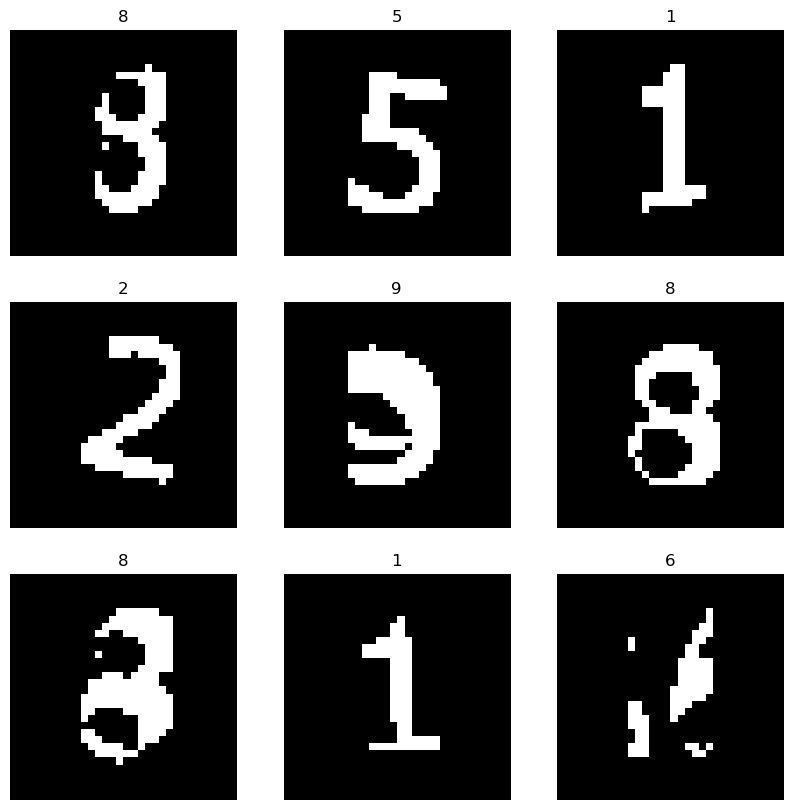

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][:, :, 0].numpy().astype("uint8"),cmap='gray', vmin=0, vmax=255)
        plt.title(int(labels[i]))
        plt.axis("off")

plt.show()


In [9]:
from tensorflow.keras import layers
from tensorflow.keras import Input
model = keras.Sequential(
    [
        layers.Reshape((1024,), input_shape=(32,32,1)),
        # layers.Conv2D(16, 3, padding="same"),
        # layers.MaxPooling2D(),
        # layers.Conv2D(8, 3, padding="same"),
        # layers.MaxPooling2D(),
        # layers.Flatten(),
        layers.Dense(64, activation="sigmoid"),
        layers.Dense(32, activation="relu"),
        layers.Dense(8, activation="sigmoid"),
        layers.Dense(10, activation="softmax")
    ]
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 10)                90        
                                                                 
Total params: 68,034
Trainable params: 68,034
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_dataset, epochs=20, verbose=2)

Epoch 1/20
200/200 - 3s - loss: 2.2091 - accuracy: 0.2273 - 3s/epoch - 15ms/step
Epoch 2/20
200/200 - 2s - loss: 1.8916 - accuracy: 0.4942 - 2s/epoch - 8ms/step
Epoch 3/20
200/200 - 1s - loss: 1.6821 - accuracy: 0.5279 - 1s/epoch - 7ms/step
Epoch 4/20
200/200 - 1s - loss: 1.5303 - accuracy: 0.5505 - 1s/epoch - 7ms/step
Epoch 5/20
200/200 - 2s - loss: 1.3846 - accuracy: 0.6184 - 2s/epoch - 8ms/step
Epoch 6/20
200/200 - 2s - loss: 1.2718 - accuracy: 0.6414 - 2s/epoch - 8ms/step
Epoch 7/20
200/200 - 2s - loss: 1.1928 - accuracy: 0.6718 - 2s/epoch - 9ms/step
Epoch 8/20
200/200 - 3s - loss: 1.1083 - accuracy: 0.7193 - 3s/epoch - 16ms/step
Epoch 9/20
200/200 - 2s - loss: 1.0507 - accuracy: 0.7193 - 2s/epoch - 10ms/step
Epoch 10/20
200/200 - 3s - loss: 0.9786 - accuracy: 0.7548 - 3s/epoch - 15ms/step
Epoch 11/20
200/200 - 3s - loss: 0.9529 - accuracy: 0.7515 - 3s/epoch - 15ms/step
Epoch 12/20
200/200 - 2s - loss: 0.9183 - accuracy: 0.7606 - 2s/epoch - 12ms/step
Epoch 13/20
200/200 - 3s - loss

In [11]:
loss, acc = model.evaluate(train_dataset)  # returns loss and metrics
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)

200/200 [==============================] - 2s 10ms/step - loss: 0.6969 - accuracy: 0.8053
loss: 0.70
acc: 0.81


In [12]:
import numpy as np

predictions = model.predict(test_dataset)
print(f"validation shape:{predictions.shape}\n")
print(f"prediction for first sample:{predictions[0]}\n")

# Generate arg maxes for predictions
classes = np.argmax(predictions, axis = 1)

50/50 [==============================] - 1s 7ms/step
validation shape:(599, 10)

prediction for first sample:[0.00226266 0.0401898  0.63007605 0.00512945 0.01926128 0.00127944
 0.01471487 0.27660543 0.00532464 0.00515634]



# Run prediction
for prediction you can download your new captcha from :https://result2.sanjesh.org/RSEmp/EmpBonyad1400Exp/CaptchaHandler.ashx and upload in "predict" directory and your predicted number will generate at "predicted" folder, you can repeat this steps to new guess new Captcha

In [13]:
import io

In [ ]:

from google.colab import files

uploaded = files.upload()
img = Image.open(io.BytesIO(uploaded['CaptchaHandler.jpg']))

predict_image_path = "predict/CaptchaHandler.jpg"
img.save(predict_image_path)

#### prepace image for prediction unsharp mask filter > threashold > split > padding > save generated image 


Saving CaptchaHandler.jpg to CaptchaHandler (4).jpg


In [18]:
run_prediction_image_preprocess()

Found 3 files belonging to 1 classes.
1/1 [==============================] - 0s 30ms/step
3
[4 5 4]
Data for prediction has been created in location: predicted/


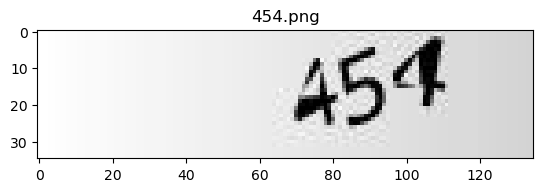

In [19]:

prediction_dataset = keras.preprocessing.image_dataset_from_directory(
    predictionFilesPath,
    labels=None,
    color_mode="grayscale",
    batch_size=32,
    image_size=(32, 32),
    shuffle=False,
    seed=42,
    interpolation="nearest"
)

# call model prediction
predictions = model.predict(prediction_dataset)

# show classes of prediction
classes = np.argmax(predictions, axis = 1)
print(len(classes))
print(classes)

# just generate and show new image
from PIL import Image
predicted_image_path ="predicted/"
print(f"Data for prediction has been created in location: {predicted_image_path}")
img = Image.open("predict/CaptchaHandler.jpg")
#img = Image.open(io.BytesIO(uploaded['CaptchaHandler.jpg']))


plt.imshow(np.asarray(img),cmap='gray', vmin=0, vmax=255)
plt.title(f"{classes[0]}{classes[1]}{classes[2]}.png")

plt.show()
img.save(f"{predicted_image_path}{classes[0]}{classes[1]}{classes[2]}.png")

In [ ]:
os.